Saving merged.csv to merged (3).csv


Saving recession.csv to recession (1).csv


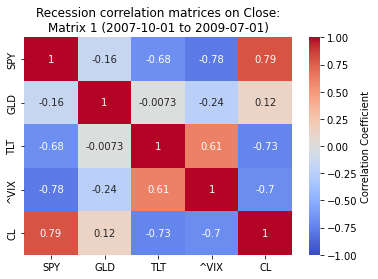

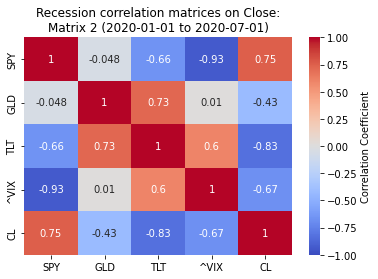

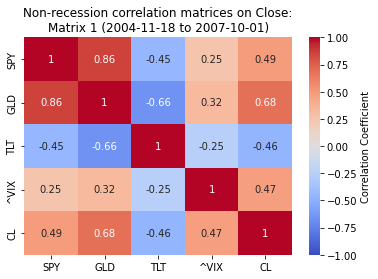

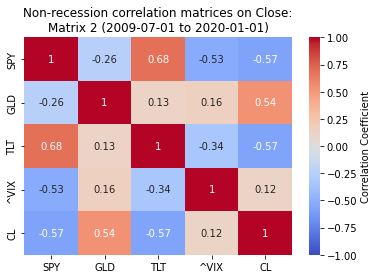

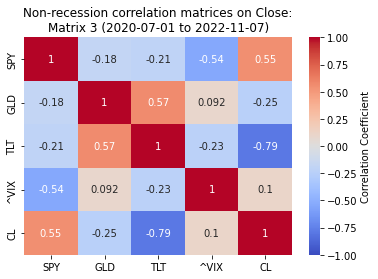

In [4]:
import pandas as pd
import numpy as np

def load_data(asset_name, start_date, end_date):
    
    from google.colab import files
    uploaded = files.upload()
    import io
    data= pd.read_csv(io.BytesIO(uploaded['merged.csv']))
    normal_df = data.copy()
    normal_df.drop(['FinQuarter'],inplace=True, axis=1)
    normal_df['Date'] = pd.to_datetime(normal_df['Date'], dayfirst=True)
    normal_df= normal_df.set_index('Date')
    return normal_df.loc[start_date:end_date]

def get_recession_periods(recession_df):
    recession_periods = []
    non_recession_periods = []

    start_period = recession_df.index[0]
    current_recession = recession_df.iloc[0]['JHDUSRGDPBR']

    for date, row in recession_df.iterrows():
        if row['JHDUSRGDPBR'] != current_recession:
            if current_recession:
                recession_periods.append((start_period, date))
            else:
                non_recession_periods.append((start_period, date))
            start_period = date
            current_recession = row['JHDUSRGDPBR']

    if current_recession:
        recession_periods.append((start_period, date))
    else:
        non_recession_periods.append((start_period, date))

    return recession_periods, non_recession_periods

def calculate_correlations(asset_data, periods):
    correlations = []
    for start_date, end_date in periods:
        period_data = asset_data.loc[start_date:end_date].dropna()
        correlations.append(period_data.corr())
    return correlations
start_date = '2004-11-18'
end_date = '2022-12-31'

merged_data = load_data("Merged_Close", start_date, end_date)

from google.colab import files
uploaded = files.upload()
import io
recession_df= pd.read_csv(io.BytesIO(uploaded['recession.csv']))
recession_df['Date'] = pd.to_datetime(recession_df['Date'], dayfirst=True)
recession_df = recession_df.set_index('Date').resample('D').ffill().loc[start_date:end_date]

recession_periods, non_recession_periods = get_recession_periods(recession_df)

recession_correlations = calculate_correlations(merged_data, recession_periods)
non_recession_correlations = calculate_correlations(merged_data, non_recession_periods)

import seaborn as sns
#for heatmap visualisation
import matplotlib.pyplot as plt

def plot_correlation_matrices(matrices, periods, title):
    for i, (corr_matrix, period) in enumerate(zip(matrices, periods)):
        start_date, end_date = period
        plt.figure()
        ax = sns.heatmap(corr_matrix.round(4), annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
        ax.set_title(f"{title}\nMatrix {i + 1} ({start_date.date()} to {end_date.date()})")
        plt.show()

plot_correlation_matrices(recession_correlations, recession_periods, "Recession correlation matrices on Close:")
plot_correlation_matrices(non_recession_correlations, non_recession_periods, "Non-recession correlation matrices on Close:")